# Tolgo – Risk & Anomaly Detection Analysis  
### Fintech Transaction Risk Monitoring (Python)

This notebook analyzes transaction-level data to detect unusual or risky behaviors,  
using rule-based methods commonly used in fintech operational risk.

The analysis includes:

- Amount-based anomaly detection (Z-score)
- Rapid consecutive transactions
- Repeated top-ups in short intervals
- Combined anomaly scoring
- Risk flags & visualizations


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [6]:
df = pd.read_csv("../Data/transactions.csv", parse_dates=["time"])
df = df.sort_values("time")
df.head()

,transaction_id,user_id,amount,time,method,topup_flag
0,943,user_3,1393.72,2024-01-01 12:00:39,bank_transfer,0
1,618,user_8,4041.18,2024-01-01 12:01:48,card,1
2,450,user_31,4993.97,2024-01-01 12:02:31,card,1
3,273,user_37,3846.46,2024-01-01 12:03:14,bank_transfer,0
4,976,user_12,5088.52,2024-01-01 12:06:03,bank_transfer,0


In [7]:
df["topup_flag"] = df["topup_flag"].astype(int)
df["hour"] = df["time"].dt.hour
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1000 non-null   int64         
 1   user_id         1000 non-null   object        
 2   amount          1000 non-null   float64       
 3   time            1000 non-null   datetime64[ns]
 4   method          1000 non-null   object        
 5   topup_flag      1000 non-null   int64         
 6   hour            1000 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(2)
memory usage: 50.9+ KB


## 1. Amount-Based Anomaly Detection (Z-score)

Large payments far from the statistical norm (mean ± 2.5 std) are considered unusual.  
This is a simple and common rule in fintech transaction monitoring.


In [15]:
df["zscore_amount"] = (df["amount"] - df["amount"].mean()) / df["amount"].std()
df["amount_flag"] = (abs(df["zscore_amount"]) > 2.0).astype(int)

df[["amount", "zscore_amount", "amount_flag"]].head(10)


,amount,zscore_amount,amount_flag
0,1393.72,-1.525556,0
1,4041.18,-0.432416,0
2,4993.97,-0.039007,0
3,3846.46,-0.512816,0
4,5088.52,0.000033,0
5,5284.10,0.080788,0
6,4701.62,-0.159719,0
7,8693.61,1.488580,0
8,7344.48,0.931522,0
9,2613.68,-1.021832,0


## 2. Rapid Consecutive Transactions (< 60 seconds)

Fraud attempts or account misuse often involve very fast repeated transactions.  
We flag events occurring less than 60 seconds after the previous one.


In [16]:
df["previous_time"] = df.groupby("user_id")["time"].shift(1)
df["time_diff_sec"] = (df["time"] - df["previous_time"]).dt.total_seconds()
df["rapid_flag"] = (df["time_diff_sec"] <= 120).astype(int)

df[["user_id", "time", "time_diff_sec", "rapid_flag"]].head(10)

,user_id,time,time_diff_sec,rapid_flag
0,user_3,2024-01-01 12:00:39,NaN,0
1,user_8,2024-01-01 12:01:48,NaN,0
2,user_31,2024-01-01 12:02:31,NaN,0
3,user_37,2024-01-01 12:03:14,NaN,0
4,user_12,2024-01-01 12:06:03,NaN,0
5,user_21,2024-01-01 12:09:55,NaN,0
6,user_6,2024-01-01 12:10:12,NaN,0
7,user_5,2024-01-01 12:21:25,NaN,0
8,user_6,2024-01-01 12:21:25,673.0,0
9,user_40,2024-01-01 12:34:13,NaN,0


## 3. Frequent Top-Ups (Rolling Window)

Multiple top-ups in a very short window may indicate risky patterns  
such as account manipulation or system abuse.


In [17]:
df["rolling_topups"] = (
    df.groupby("user_id")["topup_flag"]
    .rolling(window=3, min_periods=1)
    .sum()
    .reset_index(0, drop=True)
)

df["freq_flag"] = (df["rolling_topups"] >= 2).astype(int)

df[["user_id", "topup_flag", "rolling_topups", "freq_flag"]].head(10)

,user_id,topup_flag,rolling_topups,freq_flag
0,user_3,0,0.0,0
1,user_8,1,1.0,0
2,user_31,1,1.0,0
3,user_37,0,0.0,0
4,user_12,0,0.0,0
5,user_21,1,1.0,0
6,user_6,0,0.0,0
7,user_5,0,0.0,0
8,user_6,0,0.0,0
9,user_40,0,0.0,0


## 4. Anomaly Score

We combine the 3 rule-based risk indicators into a simple score.

A transaction is flagged as **anomalous** if the score ≥ 2.


In [18]:
df["anomaly_score"] = df["amount_flag"] + df["rapid_flag"] + df["freq_flag"]
df["is_anomaly"] = (df["anomaly_score"] >= 1).astype(int)

df["is_anomaly"].value_counts()

is_anomaly
0    782
1    218
Name: count, dtype: int64

## 5. Visualization of Anomalies

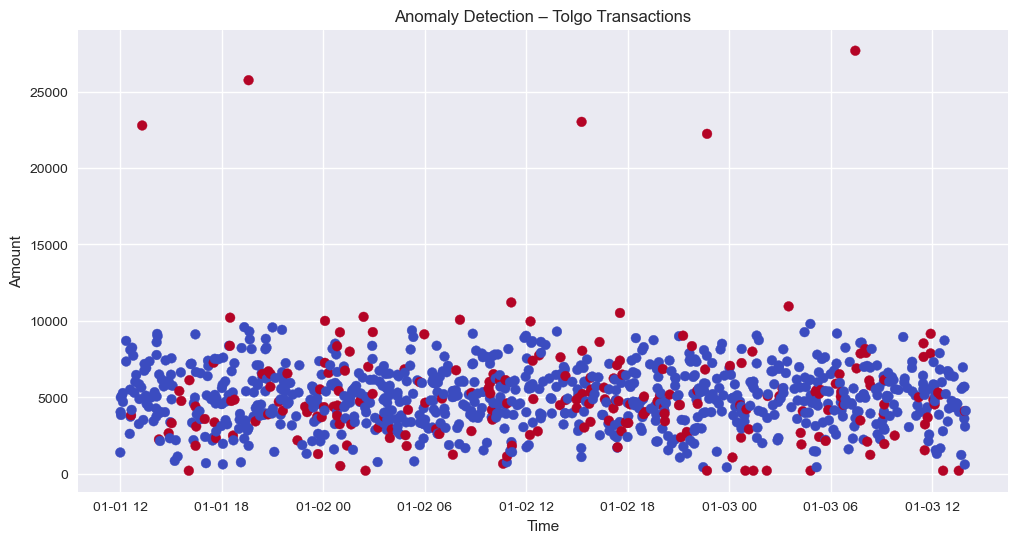

In [19]:
plt.figure(figsize=(12,6))
plt.scatter(df["time"], df["amount"], c=df["is_anomaly"], cmap="coolwarm")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.title("Anomaly Detection – Tolgo Transactions")
plt.show()

In [13]:
df.to_csv("../Data/transactions_scored.csv", index=False)
print("Exported!")

Exported!


In [21]:
import sys
sys.path.append("../Scripts")

In [22]:
from utils import *

total_revenue(df)

np.float64(5088440.84)